In [1]:
import warnings # suppress warnings
warnings.filterwarnings('ignore')
#########################################
import os
import gc
import glob
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from pathlib import Path
#########################################
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
!ls ../input/*
#########################################
pd.set_option('display.max_columns', 500)

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
df_sample = pd.read_csv('./submission.csv')
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')


df_train.drop(["id"], inplace=True, axis=1)

original = pd.read_csv('./mixed_desc.csv')
original['EC1'] = [int(f[0])  for f in original['EC1_EC2_EC3_EC4_EC5_EC6']]
original['EC2'] = [int(f[2])  for f in original['EC1_EC2_EC3_EC4_EC5_EC6']] 
original['EC3'] = [int(f[4])  for f in original['EC1_EC2_EC3_EC4_EC5_EC6']]
original['EC4'] = [int(f[6])  for f in original['EC1_EC2_EC3_EC4_EC5_EC6']]
original['EC5'] = [int(f[8])  for f in original['EC1_EC2_EC3_EC4_EC5_EC6']]
original['EC6'] = [int(f[10]) for f in original['EC1_EC2_EC3_EC4_EC5_EC6']]

df_org = original[df_train.columns]


df_train = pd.concat([df_train, df_org], axis = 0).reset_index(drop=True)

# check null
MV1 = df_train.isnull().sum()
MV2 = df_test.isnull().sum()

# check duplicates
df_train.duplicated().value_counts() 
df_test.duplicated().value_counts()

df_train = df_train.drop_duplicates()

col = [c for c in df_train.columns.tolist() if c not in df_test.columns.tolist()]
df_sample.columns.tolist()

test = df_test.copy()
train = df_train.drop(columns=col)
target = df_train[['EC1','EC2']]




31


,Train,Test
BertzCT,2375.0,1811
Chi1,1267.0,1047
Chi1n,3184.0,2473
Chi1v,3323.0,2604
Chi2n,3665.0,2806
Chi2v,3752.0,2858
Chi3v,3460.0,2644
Chi4n,2948.0,2249
EState_VSA1,731.0,582
EState_VSA2,446.0,380


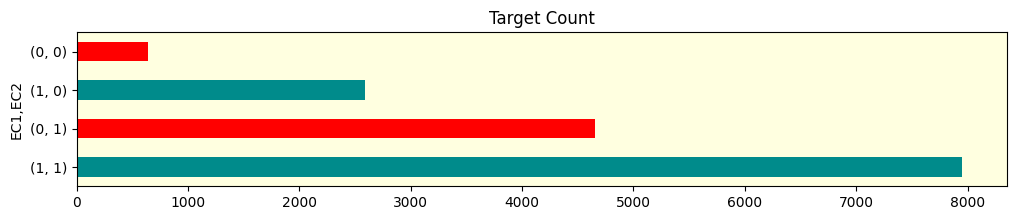

In [24]:
#target graph
target.value_counts().plot(kind='barh', figsize=(12,2), title='Target Count', color=['darkcyan','red'])
plt.gca().set_facecolor('lightcyan')

pd.DataFrame(data= {'Number': target.value_counts(), 'Percent': target.value_counts(normalize=True)})


target_org = df_org[['EC1','EC2']]

target_org.value_counts().plot(kind='barh', figsize=(12,2), title='Target Count', color=['darkcyan','red'])
plt.gca().set_facecolor('lightyellow')

pd.DataFrame(data= {'Number': target_org.value_counts(), 'Percent': target_org.value_counts(normalize=True)})

features = train.columns.tolist()
print(len(features))

pd.DataFrame(data= {'Train': train.nunique(), 'Test': test.nunique()})

In [25]:
# categorical features
cat_features = [f for f in features if train[f].dtype==int]
cat_features
s_train1 = set(train['NumHeteroatoms'])
s_test1 = set(test['NumHeteroatoms'])
up1 = list(set(s_train1.union(s_test1)))

print(len(s_train1) == len(up1))
print(len(up1))

s_train2 = set(train['fr_COO'])
s_test2 = set(test['fr_COO'])
up2 = list(set(s_train2.union(s_test2)))

print(len(s_train2) == len(up2))
print(len(up2))

s_train3 = set(train['fr_COO2'])
s_test3 = set(test['fr_COO2'])
up3 = list(set(s_train3.union(s_test3)))

print(len(s_train3) == len(up3))
print(len(up3))

False
44
False
9
False
9


In [26]:
# numerical features

num_features = [f for f in features if f not in cat_features]
len(num_features)
# sns.set()
# plt.style.use('seaborn-whitegrid') 
# _, axs = plt.subplots(11, 3, figsize=(15,45), facecolor='lightblue')

# for f, ax in zip(features, axs.ravel()):
#     ax.set_facecolor('lightcyan')
#     ax.hist(train[f], bins=30, color='red')
#     ax.set_title(f'Feature: {f}', fontsize=10)

# plt.suptitle('Histograms of the Features', y=0.90, fontsize=32, color='lightcyan')
# plt.show()


# cor_matrix = df_train[features + ['EC1','EC2']].corr()
# fig = plt.figure(figsize=(12,12));

# cmap=sns.diverging_palette(240, 10, s=75, l=50, sep=1, n=6, center='light', as_cmap=False);
# sns.heatmap(cor_matrix, center=0, annot=False, cmap=cmap, linewidths=2);
# plt.show()

31

In [27]:
# convert Categorical features : ONE HOT ENCODER

train_code = pd.get_dummies(train, columns=cat_features)
test_code = pd.get_dummies(test, columns=cat_features)

train_code.shape, test_code.shape



# Overlap for features
f_train = train_code.columns.tolist()
f_test = test_code.columns.tolist()

f_overlap = [f for f in f_test if f in f_train]

train_code = train_code[f_overlap]
test_code = test_code[f_overlap]

train_code.shape, test_code.shape


# Scale the numerical features
from sklearn.preprocessing import StandardScaler, LabelEncoder
# scaler = StandardScaler()

# train_code[num_features] = scaler.fit_transform(train_code[num_features])
# test_code[num_features] = scaler.fit_transform(test_code[num_features])

In [28]:
#evalution metric

from sklearn.metrics import roc_auc_score, roc_curve, auc

def roc_auc(true_list, pred_list, a, b):
    
    fpr, tpr, _ = roc_curve(true_list, pred_list)    
    roc_auc = auc(fpr, tpr)
    
    print(f'\n>>>>> ROC_AUC: %0.6f <<<<<\n' %roc_auc)
    
    sns.set()
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(a, b), facecolor='lightblue')
    plt.gca().set_facecolor('lightcyan')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The area under the ROC curve\n')
    plt.legend(loc="lower right")
    plt.show()

(0.1223710543970147, 0.9999997765240743)

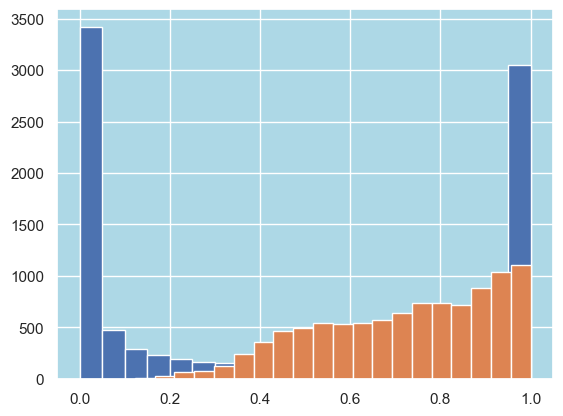

In [30]:
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import QuantileTransformer

# prediction
transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(train_code))
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(train_code, target['EC1'])



cross_val_score(pipeline, train_code, target['EC1'], scoring='roc_auc' , cv=10).mean()

preds_bayes1 = pipeline.predict_proba(test_code)[:,1]
preds_bayes1


# prediction histogram ec1
sns.set()
plt.hist(preds_bayes1, bins=20)
plt.gca().set_facecolor('lightblue')
min(preds_bayes1), max(preds_bayes1)


transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(train_code))
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(train_code, target['EC2'])


cross_val_score(pipeline, train_code, target['EC2'], scoring='roc_auc' , cv=7).mean()

preds_bayes2 = pipeline.predict_proba(test_code)[:,1]
preds_bayes2

sns.set()
plt.hist(preds_bayes2, bins=20)
plt.gca().set_facecolor('lightblue')
min(preds_bayes2), max(preds_bayes2)


In [ ]:
sub_bayes = df_sample.copy()
sub_bayes['EC1'] = preds_bayes1
sub_bayes['EC2'] = preds_bayes2
sub_bayes

sub_bayes.to_csv('submission_bayes.csv',index=False)
!ls